# Evaluation Metrics for Classification

In this project we will evaluate the results we got in churn_prediction project.  
As you know we tested our model against validation data frame and got an accuracy of 80%.  
  
The question is how good 80% accuracy and what it really means in context of model quality. 
In this project, we will answer that questions and also show another methods of evaluation of binary classification models.

In [1]:
# let's do all the steps from the churn project
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')


In [3]:

df.churn = (df.churn == 'yes').astype(int)
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']


In [4]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)


,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [5]:
X_train = dv.transform(train_dict)
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)
LogisticRegression(random_state=1, solver='liblinear')
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict) 
y_pred = model.predict_proba(X_val)[:, 1]


In [6]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)


,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [7]:

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)
LogisticRegression(random_state=1, solver='liblinear')
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

In [8]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

0.8016129032258065

## 1 - Classification Accuracy

Accuracy is the simplest method to evaulaute the classificator, by counting number of correctly predicted events and its share in total number of events.  
The first thing we need to figure out is why we chose **0.5** as the threshold
value. This was an arbitrary choice; however, in practice it is not difficult
to test other threshold values.

We can simply iterate over all possible thresholds and compute the accuracy
for each of them. Then we can choose the threshold that demonstrates the best
accuracy.


In [23]:
from sklearn.metrics import accuracy_score
thresholds = np.linspace(0, 1, 11)
for t in thresholds:
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.10 0.595
0.20 0.690
0.30 0.755
0.40 0.782
0.50 0.802
0.60 0.790
0.70 0.774
0.80 0.742
0.90 0.739
1.00 0.739


As we can see the threshold value of 0.5 gives the best accuracy, as a rule 0.5 is the good threshold value in the beginning.  
However, we need to also check the other values to make sure that 0.5 is definitely the best value.

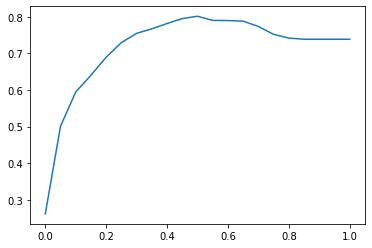

In [10]:
thresholds = np.linspace(0, 1, 21)
accuracies = []
for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
plt.plot(thresholds, accuracies)

Let's check how simpler model which used only three variables `contract`, `tenure` and `totalcharges`performs

In [11]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]


In [12]:
churn_small = y_pred_small >= 0.5
accuracy_score(y_val, churn_small)

0.7672043010752688

We see that accuracy of smaller model is 76% Thus accuracy of the bigger model is by 4% more accurate.

### 1.1 - Dummy Baseline

This metric seems good, but to determine whether **80%** is truly good, we need
to relate it to something — for example, to a simple baseline that is easy to
understand.

One such baseline can be a **dummy model** that always predicts the same value.

In our example, the dataset is not balanced, and we do not have many churned
customers. Therefore, a dummy model can always predict the majority class —
**“no churn.”** In other words, this model will always output **False**,
regardless of the features.

This is not a very useful model, but it can be used as a baseline and compared
with other models.

Let us create this baseline prediction:


In [13]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)

In [14]:
accuracy_score(baseline, y_val)

0.7387096774193549

The output is almost 74% which means accuracy of dummy baseline model is 74%.  
As we can see the smaller model is only 2% more accurate and the bigger model is just 6%.

Churn prediction is a difficult task, and this may indeed be a significant
improvement. However, this is not at all obvious if we rely only on the
accuracy metric.

According to accuracy alone, our model is only slightly better than the dummy
model, which treats all customers as reliable and does not attempt to retain
any of them.

Therefore, we need additional metrics — other ways of measuring the quality of
our model. These metrics are based on the **confusion matrix**, a concept that
we will discuss in the next section.


### 1.2 - Confusion Matrix

Although accuracy is easy to understand, it is not always the best metric.
In fact, sometimes it can even be misleading.

We have already seen how this happens: the accuracy of our model is **80%**, and
although this value seems good, it is only **6%** better than the accuracy of
the dummy model, which always produces the same prediction — **“no churn.”**

This situation usually arises when we have a **class imbalance**
(more instances of one class than of the other). We know that this definitely
applies to our task: **74%** of customers did not churn, and only **26%** did.

Such cases require a different way of measuring the quality of our models.
There are several options for this, and most of them are based on the
**confusion matrix** — a table that compactly represents all possible outcomes
of our model’s predictions.


- **True Negative (TN):** we predict **False** (“no churn”), and the actual label
  is also **False** (“no churn”).

- **True Positive (TP):** we predict **True** (“churn”), and the actual label
  is also **True** (“churn”).

- **False Negative (FN):** we predict **False** (“no churn”), but in reality
  it is **True** (the customer has churned).

- **False Positive (FP):** we predict **True** (“churn”), but in reality
  it is **False** (the customer stayed with us).


In [15]:
t = 0.5
predict_churn = (y_pred >= t) 
predict_no_churn = (y_pred < t)

In [16]:
t = 0.5
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

In [17]:
true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()


In [18]:
confusion_table = np.array( 
 [[true_negative, false_positive], 
 [false_negative, true_positive]])
confusion_table

array([[1202,  172],
       [ 197,  289]])

In [19]:
confusion_table / confusion_table.sum()


array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

The model makes many mistakes of false_positive and false_negative 9% and 11% respectively

The values from the confusion matrix form the basis for many other evaluation
metrics. For example, we can compute **accuracy** by taking all correct
predictions (**TN** and **TP**) and dividing this number by the total number of
observations across all four cells of the table:  
$$
\text{accuracy} = \frac{TN + TP}{TN + TP + FN + FP}
$$


In [24]:
churn = y_pred >= 0.5
accuracy_score(y_val, churn)

0.8016129032258065

### 1.3 -  Precision and Recall

Let us start with **precision**.  
This metric tells us how many of the positive predictions were correct.  
It is the proportion of correctly predicted positive examples.

In our case, this is the number of customers who actually churned (**TP**)
compared to the number of customers that were predicted to churn
according to our model, that is (**TP + FP**).

$$
P = \frac{TP}{TP + FP}
$$


In [28]:
precision = true_positive/(true_positive + false_positive)
print(f"Precision: {round(precision,3)*100}%")

Precision: 62.7%


**Recall** is the proportion of correctly classified positive examples
among all positive examples.

In our case, to compute recall, we first select all customers who actually
churned and then check how many of them were correctly identified by the model.

The formula for recall is:

$$
R = \frac{TP}{TP + FN}
$$


In [29]:
recall = true_positive/(true_positive+false_negative)
print(f"Recall: {round(recall,3)*100}%")

Recall: 59.5%


Model recall is the proportion of correctly predicted churned customers (**TP**)
among all customers who actually churned (**TP + FN**).


- **Precision** — the percentage of correct predictions (**TP**) among customers
  predicted as **“churn”** (**TP + FP**).

- **Recall** — the percentage of correct **“churn”** predictions (**TP**) among
  all customers who actually churned (**TP + FN**).


Both precision and recall refer to correct predictions (TP), but they use different denominators.

- For **precision**, the denominator is the number of customers predicted as churn.

- For **recall**, the denominator is the number of customers who actually churned.

**Precision** helps us understand how many people received a promotional message
by mistake. The higher the precision, the fewer false positives we have.

A precision of **62%** means that **62%** of the contacted customers were indeed
planning to churn (our true positive results), while the remaining **38%** were
not (false positive results).

**Recall** helps us understand how many churned customers we failed to detect.
The better the recall, the fewer false negatives we have.

A recall of **59%** means that we reach only **59%** of all users who plan to
leave (true positive results) and fail to detect the remaining **41%**
(false negative results).

Obviously, in both cases we do not really care about the number of
**true negative** results: even if we correctly identify that people are not
leaving, we do not plan to take any action in response.
